In [72]:
import pickle
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from itertools import combinations_with_replacement
import warnings
from typing import List, Tuple
import matplotlib.pyplot as plt

In [73]:
print("Ładowanie modeli i danych...")
with open("ig_best_models_by_circuit.pickle", "rb") as f:
    models = pickle.load(f)

with open("ig_dfs_by_circuit.pickle", "rb") as f:
    data = pickle.load(f)

available_circuits = list(models.keys())
print(f"Załadowano modele dla {len(available_circuits)} torów:")
print(available_circuits)

Ładowanie modeli i danych...
Załadowano modele dla 22 torów:
['Miami', 'Austin', 'Melbourne', 'Las Vegas', 'Mexico City', 'Jeddah', 'Yas Marina Circuit', 'Sakhir', 'Singapore', 'Imola', 'Montreal', 'Spa-Francorchamps', 'Paul Ricard', 'Silverstone', 'Baku', 'Spielberg', 'Monza', 'Suzuka', 'Catalunya', 'Zandvoort', 'Monte Carlo', 'Hungaroring']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning

In [74]:
def get_circuit_config(circuit: str) -> Dict:
    PIT_STOP_LOSSES = {
        'Austin': 20.6
        # TODO: uzupłnić danymi z internetu
    }

    CIRCUIT_LAP_TIMES = {
        'Austin': {'mean': 97.3, 'std': 1.5}
        # TODO: uzupłnić danymi z internetu
    }

    if circuit not in CIRCUIT_LAP_TIMES:
        raise ValueError(f" Brak danych dla toru {circuit}.")

    mean_lap_time = CIRCUIT_LAP_TIMES[circuit]['mean']
    std_lap_time = CIRCUIT_LAP_TIMES[circuit]['std']
    pit_stop_loss = PIT_STOP_LOSSES.get(circuit, 23.0)

    print(f"Używam danych predefiniowanych dla {circuit} "
          f"({mean_lap_time:.2f}s ± {std_lap_time:.2f}s, pit stop = {pit_stop_loss:.1f}s)")

    return {
        'mean_lap_time': mean_lap_time,
        'std_lap_time': std_lap_time,
        'pit_stop_loss': pit_stop_loss
    }

In [75]:
def generate_strategies(total_laps: int, min_stops: int = 1,
                       max_stops: int = 3) -> List[List[int]]:
    strategies = []

    min_stint_length = 8
    max_stint_length = 35
    earliest_stop = 8
    latest_stop = total_laps - 8

    possible_laps = list(range(earliest_stop, latest_stop + 1))

    for num_stops in range(min_stops, max_stops + 1):
        for strategy in combinations_with_replacement(possible_laps, num_stops):
            strategy_list = sorted(list(strategy))

            valid = True

            prev_stop = 0
            for stop in strategy_list:
                if stop - prev_stop < min_stint_length:
                    valid = False
                    break
                if stop - prev_stop > max_stint_length:
                    valid = False
                    break
                prev_stop = stop

            if valid and (total_laps - strategy_list[-1]) < min_stint_length:
                valid = False
            if valid and (total_laps - strategy_list[-1]) > max_stint_length:
                valid = False

            if valid and strategy_list not in strategies:
                strategies.append(strategy_list)

    return strategies

In [76]:
def prepare_lap_features(lap_number: int, stint_lap: int,
                         compound: str, circuit: str,
                         air_temp: float = None,
                         track_temp: float = None,
                         humidity: float = None,
                         rainfall: bool = False,
                         pressure: float = None,
                         wind_speed: float = None,
                         wind_direction: float = None) -> pd.DataFrame:
    sample_data = data[circuit]

    features = pd.DataFrame({
        'LapNumber': [lap_number],
        'TyreLife': [stint_lap],
        'FreshTyre': [1 if stint_lap == 1 else 0],
        'IsPitLap': [0],
    })

    features['AirTemp'] = air_temp if air_temp is not None else sample_data['AirTemp'].median()
    features['TrackTemp'] = track_temp if track_temp is not None else sample_data['TrackTemp'].median()
    features['Humidity'] = humidity if humidity is not None else sample_data['Humidity'].median()
    features['Pressure'] = pressure if pressure is not None else sample_data['Pressure'].median()
    features['Rainfall'] = 1 if rainfall else 0
    features['WindSpeed'] = wind_speed if wind_speed is not None else sample_data['WindSpeed'].median()
    features['WindDirection'] = wind_direction if wind_direction is not None else sample_data['WindDirection'].median()

    features['Compound_HARD'] = 1 if compound == 'HARD' else 0
    features['Compound_MEDIUM'] = 1 if compound == 'MEDIUM' else 0
    features['Compound_SOFT'] = 1 if compound == 'SOFT' else 0

    required_cols = [col for col in sample_data.columns if col != 'LapTimeZScore']

    for col in required_cols:
        if col not in features.columns:
            if sample_data[col].dtype in ['int64', 'float64']:
                features[col] = sample_data[col].median()
            else:
                features[col] = sample_data[col].mode()[0] if len(sample_data[col].mode()) > 0 else 0

    return features[required_cols]

In [77]:
def simulate_strategy(strategy: List[int], total_laps: int,
                      circuit: str, compounds: List[str] = None,
                      pit_stop_loss_seconds: float = None,
                      air_temp: float = None,
                      track_temp: float = None,
                      humidity: float = None,
                      rainfall: bool = False,
                      pressure: float = None,
                      wind_speed: float = None,
                      wind_direction: float = None) -> Tuple[float, pd.DataFrame]:
    if circuit not in models:
        raise ValueError(f"Brak modelu dla toru: {circuit}")

    model = models[circuit]

    circuit_config = get_circuit_config(circuit)
    mean_lap_time = circuit_config['mean_lap_time']
    std_lap_time = circuit_config['std_lap_time']

    if pit_stop_loss_seconds is None:
        pit_stop_loss_seconds = circuit_config['pit_stop_loss']
        print(f"  Używam kary za pit stop dla {circuit}: {pit_stop_loss_seconds}s")

    if compounds is None:
        num_stints = len(strategy) + 1
        if num_stints == 2:
            compounds = ['HARD', 'MEDIUM']
        elif num_stints == 3:
            compounds = ['MEDIUM', 'HARD', 'MEDIUM']
        elif num_stints == 4:
            compounds = ['SOFT', 'MEDIUM', 'MEDIUM', 'SOFT']
        else:
            compounds = ['MEDIUM'] * num_stints

    if len(compounds) != len(strategy) + 1:
        raise ValueError(f"Liczba mieszanek ({len(compounds)}) != liczba stintów ({len(strategy) + 1})")

    pit_stops = set(strategy)
    results = []

    current_stint = 0
    stint_lap = 1

    for lap in range(1, total_laps + 1):
        if lap in pit_stops:
            current_stint += 1
            stint_lap = 1

        lap_features = prepare_lap_features(
            lap_number=lap,
            stint_lap=stint_lap,
            compound=compounds[current_stint],
            circuit=circuit,
            air_temp=air_temp,
            track_temp=track_temp,
            humidity=humidity,
            rainfall=rainfall,
            pressure=pressure,
            wind_speed=wind_speed,
            wind_direction=wind_direction
        )

        predicted_zscore = model.predict(lap_features)[0]

        predicted_lap_time = predicted_zscore * std_lap_time + mean_lap_time

        results.append({
            'LapNumber': lap,
            'Stint': current_stint + 1,
            'StintLap': stint_lap,
            'TyreLife': stint_lap,
            'Compound': compounds[current_stint],
            'PredictedZScore': predicted_zscore,
            'PredictedLapTime': predicted_lap_time,
            'IsPitStop': lap in pit_stops
        })

        stint_lap += 1

    results_df = pd.DataFrame(results)

    total_race_time = results_df['PredictedLapTime'].sum()
    pit_stop_penalty = len(strategy) * pit_stop_loss_seconds
    total_time_with_pitstops = total_race_time + pit_stop_penalty

    results_df['CumulativeTime'] = results_df['PredictedLapTime'].cumsum()

    return total_time_with_pitstops, results_df


In [78]:
def optimize_strategy(total_laps: int, circuit: str,
                      min_stops: int = 1, max_stops: int = 3,
                      pit_stop_loss_seconds: float = None,  # ← Opcjonalne
                      air_temp: float = None,
                      track_temp: float = None,
                      humidity: float = None,
                      rainfall: bool = False,
                      top_n: int = 5,
                      test_all_compounds: bool = False) -> pd.DataFrame:
    print(f"\n{'=' * 60}")
    print(f"OPTYMALIZACJA STRATEGII DLA: {circuit}")
    print(f"{'=' * 60}")
    print(f"Liczba okrążeń: {total_laps}")
    print(f"Zakres pit stopów: {min_stops}-{max_stops}")

    strategies = generate_strategies(total_laps, min_stops, max_stops)
    print(f"Wygenerowano {len(strategies)} strategii do przetestowania\n")

    strategy_results = []

    for i, strategy in enumerate(strategies):
        if (i + 1) % 50 == 0:
            print(f"  Przetworzone {i + 1}/{len(strategies)} strategii...")

        if test_all_compounds:
            num_stints = len(strategy) + 1
            compound_combinations = get_compound_combinations(num_stints)

            best_time = float('inf')
            best_compounds = None

            for compounds in compound_combinations:
                total_time, _ = simulate_strategy(
                    strategy=strategy,
                    total_laps=total_laps,
                    circuit=circuit,
                    compounds=compounds,
                    pit_stop_loss_seconds=pit_stop_loss_seconds,
                    air_temp=air_temp,
                    track_temp=track_temp,
                    humidity=humidity,
                    rainfall=rainfall
                )

                if total_time < best_time:
                    best_time = total_time
                    best_compounds = compounds

            strategy_results.append({
                'Strategy': strategy,
                'Compounds': best_compounds,
                'NumStops': len(strategy),
                'TotalTime': best_time
            })
        else:
            total_time, _ = simulate_strategy(
                strategy=strategy,
                total_laps=total_laps,
                circuit=circuit,
                pit_stop_loss_seconds=pit_stop_loss_seconds,
                air_temp=air_temp,
                track_temp=track_temp,
                humidity=humidity,
                rainfall=rainfall
            )

            strategy_results.append({
                'Strategy': strategy,
                'NumStops': len(strategy),
                'TotalTime': total_time
            })

    results_df = pd.DataFrame(strategy_results)
    results_df = results_df.sort_values('TotalTime').reset_index(drop=True)

    results_df['TimeDelta'] = results_df['TotalTime'] - results_df['TotalTime'].iloc[0]

    results_df['TotalTimeMin'] = results_df['TotalTime'] / 60
    results_df['TimeDeltaSec'] = results_df['TimeDelta']

    print(f"\n✓ Optymalizacja zakończona!\n")
    return results_df.head(top_n)


def get_compound_combinations(num_stints: int) -> List[List[str]]:
    if num_stints == 2:
        return [
            ['HARD', 'MEDIUM'],
            ['MEDIUM', 'SOFT'],
            ['HARD', 'SOFT'],
            ['SOFT', 'MEDIUM'],
            ['MEDIUM', 'MEDIUM'],
            ['SOFT', 'SOFT'],
        ]
    elif num_stints == 3:
        return [
            ['SOFT', 'MEDIUM', 'SOFT'],
            ['MEDIUM', 'HARD', 'MEDIUM'],
            ['HARD', 'MEDIUM', 'SOFT'],
            ['SOFT', 'SOFT', 'MEDIUM'],
            ['MEDIUM', 'MEDIUM', 'SOFT'],
            ['HARD', 'HARD', 'MEDIUM'],
            ['MEDIUM', 'SOFT', 'SOFT'],
        ]
    elif num_stints == 4:
        return [
            ['SOFT', 'MEDIUM', 'MEDIUM', 'SOFT'],
            ['MEDIUM', 'HARD', 'MEDIUM', 'SOFT'],
            ['SOFT', 'SOFT', 'MEDIUM', 'SOFT'],
            ['SOFT', 'MEDIUM', 'SOFT', 'SOFT'],
        ]
    else:
        return [['MEDIUM'] * num_stints]


def plot_simulation(simulation_df, strategy, compounds):
    plt.figure(figsize=(12,6))

    plt.plot(simulation_df['LapNumber'], simulation_df['PredictedLapTime'],
             label="Przewidywany czas okrążenia", color="blue")

    pit_laps = simulation_df[simulation_df['IsPitStop']]['LapNumber']
    for lap in pit_laps:
        plt.axvline(lap, color="red", linestyle="--", alpha=0.7, label="Pit stop" if lap == pit_laps.iloc[0] else "")

    for stint in simulation_df['Stint'].unique():
        stint_data = simulation_df[simulation_df['Stint'] == stint]
        plt.axvspan(stint_data['LapNumber'].iloc[0],
                    stint_data['LapNumber'].iloc[-1],
                    alpha=0.1,
                    color="green" if stint_data['Compound'].iloc[0] == "SOFT"
                          else "yellow" if stint_data['Compound'].iloc[0] == "MEDIUM"
                          else "gray")

    plt.xlabel("Okrążenie")
    plt.ylabel("Czas [s]")
    plt.title(f"Symulacja strategii {strategy} | Mieszanki: {compounds}")
    plt.legend()
    plt.show()


TEST POJEDYNCZEJ STRATEGII
Używam danych predefiniowanych dla Austin (97.30s ± 1.50s, pit stop = 20.6s)
  Używam kary za pit stop dla Austin: 20.6s

Strategia: Pit-stopy na okrążeniach [15, 30]
Mieszanki: ['HARD', 'MEDIUM', 'SOFT']
Przewidywany całkowity czas: 5655.97s (94.27 min)

Pierwsze 10 okrążeń:
   LapNumber  Stint  TyreLife Compound  PredictedLapTime  IsPitStop
0          1      1         1     HARD         99.930148      False
1          2      1         2     HARD         97.717796      False
2          3      1         3     HARD         97.172794      False
3          4      1         4     HARD         97.078734      False
4          5      1         5     HARD         97.104498      False
5          6      1         6     HARD         97.033914      False
6          7      1         7     HARD         97.100895      False
7          8      1         8     HARD         97.062796      False
8          9      1         9     HARD         97.062796      False
9         10   

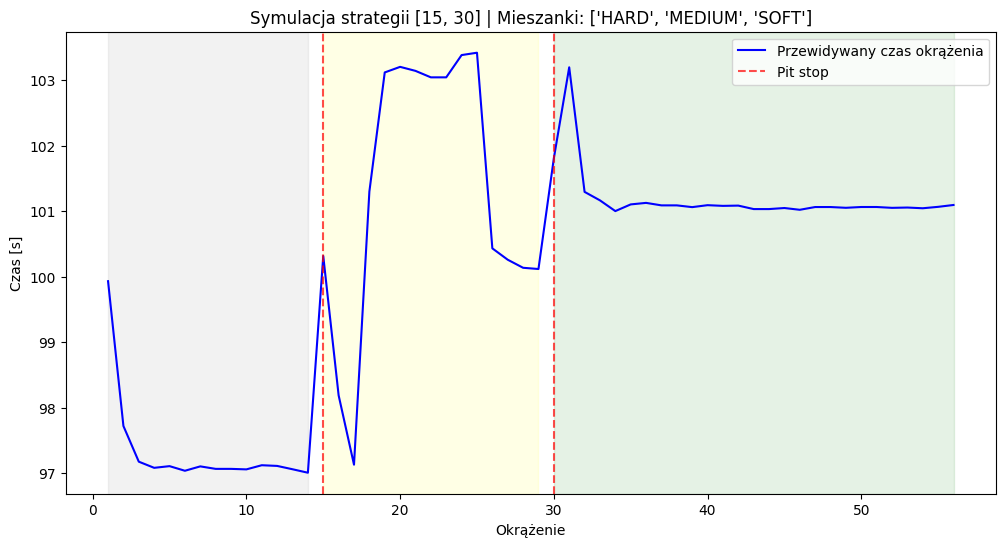

In [79]:
test_circuit = available_circuits[1]
test_strategy = [15, 30]

print("\n" + "=" * 60)
print("TEST POJEDYNCZEJ STRATEGII")
print("=" * 60)

total_time, simulation_df = simulate_strategy(
    strategy=test_strategy,
    total_laps=56, # TODO: to też by trzeba dla każdego toru oddzielnie podawać
    circuit=test_circuit,
    air_temp=33.3,
    track_temp=45.0,
    humidity=30,
    rainfall=False,
    pressure=1012,
    wind_speed=7,
    wind_direction=165,
    compounds=['HARD', 'MEDIUM', 'SOFT']
)

print(f"\nStrategia: Pit-stopy na okrążeniach {test_strategy}")
print(f"Mieszanki: ['HARD', 'MEDIUM', 'SOFT']")
print(f"Przewidywany całkowity czas: {total_time:.2f}s ({total_time / 60:.2f} min)")

print("\nPierwsze 10 okrążeń:")
print(simulation_df[['LapNumber', 'Stint', 'TyreLife', 'Compound',
                     'PredictedLapTime', 'IsPitStop']].head(10))

print("\nStatystyki dla każdego stintu:")
for stint in simulation_df['Stint'].unique():
    stint_data = simulation_df[simulation_df['Stint'] == stint]
    print(f"  Stint {stint} ({stint_data['Compound'].iloc[0]}): "
          f"średni czas = {stint_data['PredictedLapTime'].mean():.3f}s, "
          f"okrążeń = {len(stint_data)}")

plot_simulation(simulation_df, test_strategy, ['HARD','MEDIUM','SOFT'])